In [2]:
from collections import defaultdict
import csv 

import pdb
import gensim
from gensim import matutils, corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd
import nltk
import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

import snowball

In [3]:
####
# 1/15; only using tweets that contain at least one term from 
# a whitelist!
tweet_data = pd.read_csv("CancerReport-clean-whitelisted-en.txt", delimiter="\t", low_memory=False)

In [4]:
# pull out just the retweets
retweets = tweet_data[tweet_data["retweet"] == True]
unique_retweet_id_list = list(set(retweets["retweet_id_str"].tolist())) 

In [5]:
# group the tweets by the tweet they are, erm, retweeting
grouped_retweets = retweets.groupby("retweet_id_str")
# then count up retweets and extract original (retweeted) text
# see code in snowball.py for doing this
orig_tweet_texts, retweet_counts = snowball._count_up_retweets(grouped_retweets)

In [6]:
# primary tweets (non-retweets)
primary_tweets = tweet_data[tweet_data["retweet"] == False]
# now merge tweet sets (retweeted and not)
orig_tweet_texts.extend(primary_tweets["tweet_text"].values)
retweet_counts.extend([0]*primary_tweets.shape[0])
f = lambda x : x if x <= 25 else 26
clipped_retweet_counts = [f(n) for n in retweet_counts]

[(0, 26)]

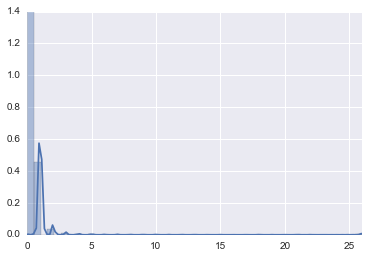

In [7]:
sns.distplot(clipped_retweet_counts).set(xlim=(0, 26))

[(0, 26)]

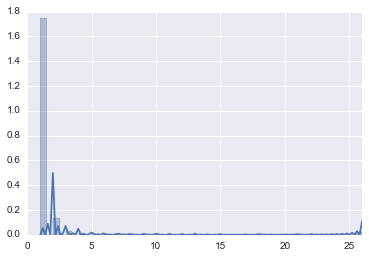

In [8]:
plt.clf()
sns.distplot([n for n in clipped_retweet_counts if n>0]).set(xlim=(0, 26))

In [9]:
### 
# now topic modeling
###

# kept_indices are the set of indices corresponding to tweets not discarded as noise 
toked_tweets, kept_indices = snowball.build_gensim_corpus(orig_tweet_texts, split_up_by_tag=False)
lda, gensim_corpus, dict_ = snowball.gen_lda_model(toked_tweets)
inferred_topic_matrix = lda.inference(gensim_corpus)[0]
# renorm, due to weirdness in gensim (???)
row_sums = inferred_topic_matrix.sum(axis=1)
inferred_topic_matrix = inferred_topic_matrix / row_sums[:, np.newaxis]

# remove the tweets that were cleaned/not included in gensim corpus
retweet_counts = [retweet_counts[idx] for idx in kept_indices]
orig_tweet_texts = [orig_tweet_texts[idx] for idx in kept_indices]


In [10]:
###
# and now regress retweet counts on inferred topic distributions (per tweet)
###

# this is just ordinary least squares (OLS)
regression_results = sm.OLS(retweet_counts, inferred_topic_matrix).fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.026
Date:                Fri, 15 Jan 2016   Prob (F-statistic):             0.0327
Time:                        08:37:16   Log-Likelihood:                -52458.
No. Observations:               12720   AIC:                         1.049e+05
Df Residuals:                   12710   BIC:                         1.050e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1482      0.606      0.245      0.8

In [11]:
# print out top words for each topic; special attention to topic 1 and 8
for topic_idx, topic in enumerate(lda.print_topics()):
    print("topic %s:\n %s\n" % (topic_idx+1, topic))

topic 1:
 0.129*co + 0.117*http + 0.070*hpv + 0.062*vaccine + 0.059*gardasil + 0.017*via + 0.016*https + 0.016*vaccines + 0.013*effects + 0.012*side

topic 2:
 0.138*cancer + 0.125*cervical + 0.084*co + 0.080*http + 0.024*women + 0.015*screening + 0.011*test + 0.009*amp + 0.009*year + 0.009*rt

topic 3:
 0.131*hpv + 0.083*co + 0.082*http + 0.044*vaccine + 0.016*girls + 0.014*human + 0.013*boys + 0.012*warts + 0.012*vaccines + 0.012*study

topic 4:
 0.107*co + 0.105*http + 0.099*hpv + 0.044*vaccine + 0.021*cancer + 0.019*vaccination + 0.013*girls + 0.011*study + 0.011*risk + 0.010*new

topic 5:
 0.177*pap + 0.121*smear + 0.047*smears + 0.019*get + 0.015*test + 0.014*rt + 0.009*dr + 0.009*lol + 0.009*women + 0.009*need

topic 6:
 0.055*hpv + 0.030*girls + 0.023*sex + 0.019*less + 0.018*teenage + 0.017*states + 0.016*likely + 0.015*documentary + 0.014*women + 0.014*adverse

topic 7:
 0.081*cancer + 0.076*cervical + 0.075*co + 0.075*http + 0.021*awareness + 0.012*amp + 0.010*know + 0.009*r

In [12]:
top_topic_tweet_indices = inferred_topic_matrix[:,0].argsort()[-20:]
print("\n\n".join([orig_tweet_texts[idx] for idx in top_topic_tweet_indices]))

BOMBSHELL: Merck's former doctor, Dr Bernard Dalbergue (France), predicts that Gardasil will become the greatest... http://t.co/ReCaiZEH8H

Japan withdraws support for HPV vaccines due to infertility side effects http://t.co/6njxAmo4yL

HPV Vaccine Victim Sues Merck | Gardasil Dangers http://t.co/KyWJqnTxWz via @mercola

Japan withdraws support for HPV vaccines due to infertility side effects http://t.co/0DbjfkJ667

France not convinced that #Gardasil is safe or effective - questions why Borax is in the vaccine http://t.co/F2HBoJPe #vaxfax

France not convinced that #Gardasil is safe or effective - questions why Borax is in the vaccine http://t.co/lXzf2bkxfY #vaxfax

Japan withdraws support for HPV vaccines due to infertility side effects http://t.co/MJ4ofcPXyn

The Gardasil Problem: How the U.S. Lost Faith in a Promising Vaccine  http://t.co/MDahwSvVMa by @matthewherper via @Forbes

#Japan withdraws support for HPV vaccines due to infertility side effects: http://t.co/DsFUmk8t90

#Jap